<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/main/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [3]:
%%capture
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

In [4]:
from dul_2021.utils.hw1_utils import *

In [5]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


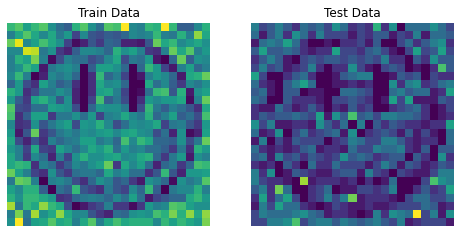

Dataset 2


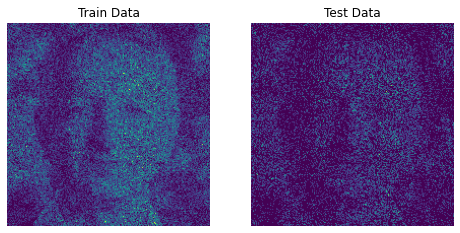

In [6]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

In [149]:
# F.one_hot(torch.as_tensor(get_data_q1_a(dset_type=1)), num_classes=25).flatten(1).shape

get_data_q1_a(dset_type=1)[:, 0].min()

0

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [302]:
import torch
import numpy as np
import torch.nn as nn
# import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import trange, tqdm

def device():
    return "cuda" if torch.cuda.is_available() else "cpu"

def get_joint_dist(model, d, device="cpu"):
    xs = torch.eye(d, device=device)
    ys = torch.eye(d, device=device)

    dist = torch.zeros((d, d))

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            inp = torch.cat((x, y)).unsqueeze(0).to(device)
            
            onehot_prob = model.predict_proba(inp)[0]

            prob_x = onehot_prob[0].dot(x)
            prob_y = onehot_prob[1].dot(y)

            dist[i, j] = prob_x * prob_y

    return dist.cpu().numpy()

class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(mask)
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
        

class MADE(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_classes):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_classes = num_classes

        self.model = nn.Sequential(
            MaskedLinear(input_dim * num_classes, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            MaskedLinear(hidden_dim, output_dim * num_classes)
        )
        masks = self.sample_masks(num_layers=2)

        for i, linear in enumerate(self.model[::2]):
            linear.set_mask(masks[i].T)

    def sample_masks(self, num_layers):
        ids = {
            -1: torch.repeat_interleave(torch.arange(self.input_dim), self.num_classes)
        }
        for l in range(num_layers):
            ids[l] = torch.randint(ids[l - 1].min(), self.input_dim - 1, size=(self.hidden_dim,)) # .reshape(-1, 1)

        masks = [ids[l - 1][:, None] <= ids[l][None, :] for l in range(num_layers)]
        masks.append(ids[num_layers - 1][:, None] < ids[-1][None, :])  # last mask

        return masks

    def forward(self, x):
        return self.model(x).reshape(-1, self.output_dim, self.num_classes)

    @torch.no_grad()
    def predict_proba(self, x):
        return F.softmax(self.forward(x), dim=-1)

    @torch.no_grad()
    def sample(self, num_samples):
        result = torch.zeros((num_samples, self.input_dim, self.num_classes)).to(device())
        for o in range(self.output_dim):
            hist = self.predict_proba(result.flatten(1)) # [n, out, classes]

            for i in range(self.input_dim):
                cls = torch.multinomial(hist[:, i], num_samples=1).flatten()
                result[:, i, cls] = 1 
                # print(i, cls, result[:, i, cls])
        
        return result.cpu().numpy()

    def fit(self, train_dataloader, test_dataloader, epochs, lr, clip_grad=None):
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        loss_info = {"test": [self.test(test_dataloader)], "train": []}

        for _ in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch[0].to(device())

                pred_class = self.forward(batch.flatten(1)).transpose(1, 2)  # ???
                true_class = torch.argmax(batch, dim=-1)

                loss = F.cross_entropy(pred_class, true_class)
                loss_info["train"].append(loss.item())

                optim.zero_grad()
                loss.backward()
                if clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                optim.step()

            loss_info["test"].append(self.test(test_dataloader))

        return loss_info

    @torch.no_grad()
    def test(self, test_dataloader):
        losses = []
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            batch = batch[0].to(device())

            pred_class = self.forward(batch.flatten(1)).transpose(1, 2) 
            true_class = torch.argmax(batch, dim=-1)

            loss = F.cross_entropy(pred_class, true_class)
            losses.append(loss.item())

        return np.mean(losses).item()

In [299]:
test_model = MADE(20 * 20, 20 * 20, 8, 2)
test_data = torch.randn(32, 2, 25)
# masks = test_model.sample_masks(3)

In [300]:
# test_model.predict_proba(test_data.flatten(1)).sum(1)
# get_joint_dist(test_model, 25, device="cpu").sum()
import matplotlib.pyplot as plt

plt.imshow(np.argmax(test_model.sample(1), -1).reshape(20, 20), cmap="gray")

Выходные данные были обрезаны до нескольких последних строк (5000).
393 tensor([1]) tensor([[1.]])
394 tensor([0]) tensor([[1.]])
395 tensor([1]) tensor([[1.]])
396 tensor([0]) tensor([[1.]])
397 tensor([0]) tensor([[1.]])
398 tensor([1]) tensor([[1.]])
399 tensor([0]) tensor([[1.]])
0 tensor([0]) tensor([[1.]])
1 tensor([0]) tensor([[1.]])
2 tensor([1]) tensor([[1.]])
3 tensor([1]) tensor([[1.]])
4 tensor([1]) tensor([[1.]])
5 tensor([1]) tensor([[1.]])
6 tensor([0]) tensor([[1.]])
7 tensor([1]) tensor([[1.]])
8 tensor([0]) tensor([[1.]])
9 tensor([0]) tensor([[1.]])
10 tensor([0]) tensor([[1.]])
11 tensor([1]) tensor([[1.]])
12 tensor([1]) tensor([[1.]])
13 tensor([0]) tensor([[1.]])
14 tensor([1]) tensor([[1.]])
15 tensor([0]) tensor([[1.]])
16 tensor([0]) tensor([[1.]])
17 tensor([1]) tensor([[1.]])
18 tensor([0]) tensor([[1.]])
19 tensor([1]) tensor([[1.]])
20 tensor([1]) tensor([[1.]])
21 tensor([1]) tensor([[1.]])
22 tensor([0]) tensor([[1.]])
23 tensor([0]) tensor([[1.]])
24 te

KeyboardInterrupt: ignored

In [231]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    train_dataset = TensorDataset(F.one_hot(torch.as_tensor(train_data), num_classes=d).float())
    test_dataset = TensorDataset(F.one_hot(torch.as_tensor(test_data), num_classes=d).float())

    train_dataloader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

    model = MADE(2, 2, hidden_dim=32, num_classes=d)
    model.to(device())

    loss_info = model.fit(train_dataloader, test_dataloader, epochs=25, lr=1e-3, clip_grad=1)

    with torch.no_grad():
        dist = get_joint_dist(model, d, device())

    return loss_info["train"], loss_info["test"], dist

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Final Test Loss: 3.1784


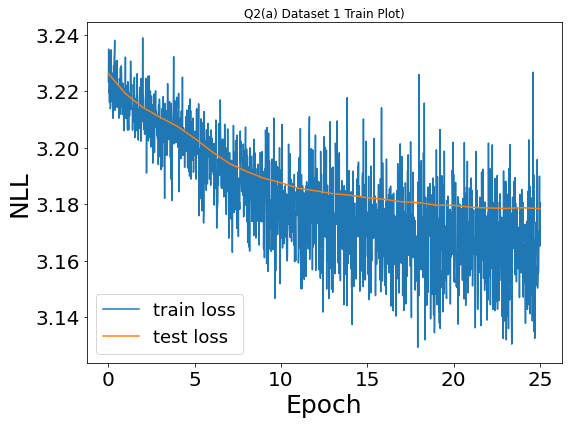

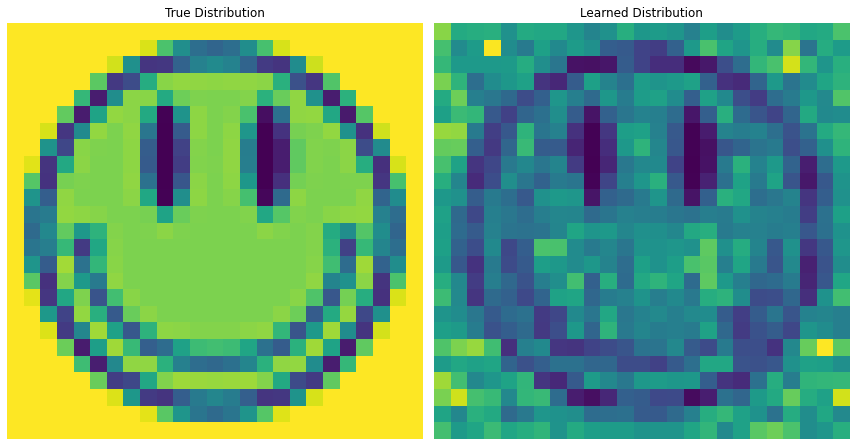

In [232]:
q1_save_results(1, 'a', q1_a)

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

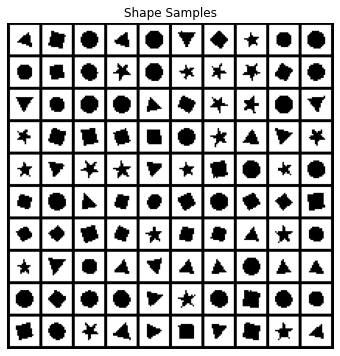

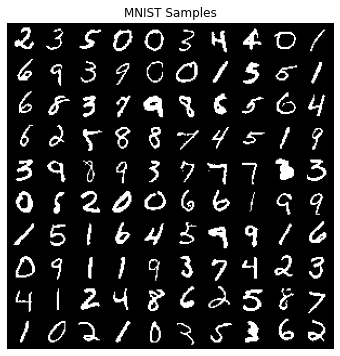

In [ ]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [271]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    H, W = image_shape
    print(H, W)
    train_dataset = TensorDataset(F.one_hot(torch.as_tensor(train_data, dtype=torch.long).flatten(1), num_classes=2).float())
    test_dataset = TensorDataset(F.one_hot(torch.as_tensor(test_data, dtype=torch.long).flatten(1), num_classes=2).float())

    train_dataloader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

    model = MADE(H*W, H*W, hidden_dim=128, num_classes=2)
    model.to(device())

    loss_info = model.fit(train_dataloader, test_dataloader, epochs=5, lr=1e-3, clip_grad=1)

    sample = np.argmax(model.sample(num_samples=100), axis=-1).reshape(100, H, W, 1)

    # torch.save("model.pt", model)


    return loss_info["train"], loss_info["test"], sample

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [272]:
q1_save_results(1, 'b', q1_b)

20 20


Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Final Test Loss: 0.1911


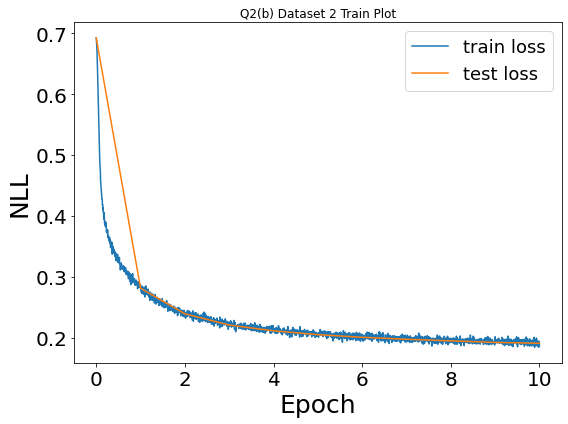

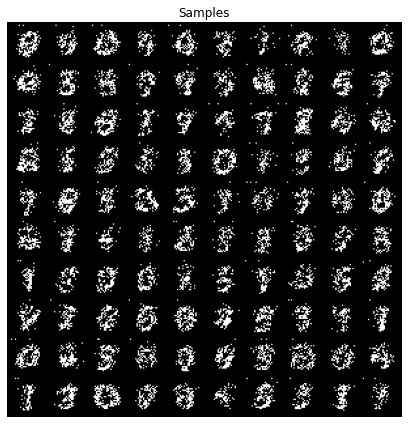

In [ ]:
q1_save_results(2, 'b', q1_b)